### Thinking1
参数共享指的是什么？

### Thinking2
为什么会用到batch normalization ?

### Thinking3
使用dropout可以解决什么问题？

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/colab')
os.getcwd()

'/content/drive/My Drive/colab'

In [3]:
pip install torch

### Action1
使用任何神经网络框架，对CIFAR-10进行分类
http://www.cs.toronto.edu/~kriz/cifar.html
训练集 50000，测试集 10000
图像大小 32*32 彩色
10个分类：ariplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 数据加载
# resize
train_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
# 对训练集还可以采取其他图片增强，如中心裁剪
# train_transform = transforms.Compose([transforms.Resize((224,224)),transforms.CenterCrop(196),transforms.ToTensor()])

train_data = datasets.CIFAR10(root='./cifar10/', train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10(root='./cifar10/', train=False, transform=train_transform, download=True)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


(3, 224, 224)


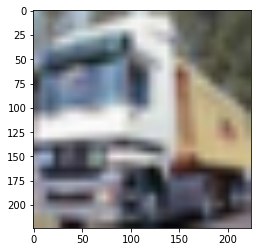

In [8]:
# 图像显示
import matplotlib.pyplot as plt
temp = train_data[1][0].numpy()
print(temp.shape)
plt.imshow(temp.transpose(1,2,0)) # 将输入调换为（32，32，3）

In [9]:
# 使用Dataloder进行分批
from torch.utils.data import DataLoader
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=2)

In [10]:
# 查看GPU是否可用
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [4]:
# 训练
def model_training(model, criterion, optimizer, epochs=5, verbose=False):
    import time
    # 定义device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_list = []
    start = time.time()
    for epoch in range(epochs):
        start_each = time.time()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播
            outputs = model(inputs)
            # 计算损失函数
            loss = criterion(outputs, labels)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
        loss_list.append(loss.item())
        if verbose == True:
            print('epoch{} loss{: .4f} time{: .4f}'.format(epoch+1, loss.item(), time.time()-start_each))
    print('平均每个epoch训练时长：{: .4f}'.format((time.time()-start)/epochs))
    return loss_list, model    

In [3]:
# 测试
def model_test(model):
    model.eval() # 固定参数
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    correct, total = 0, 0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 预测结果
        _, pred = torch.max(outputs.data, dim=1) # 取评分最高的类，dim=0是每列的最大值，dim=1是每行的最大值，返回两个值，一个是最大值tensor组一个是最大值所在的位置
        # 对比结果与真实值
        total += labels.size()[0]
        correct += (pred==labels).sum().item()
    print('10000张测试图像的准确率为：{: .4f}%'.format(100*correct/total))      

In [10]:
# 定义超参数
EPOCHS = 10
LR = 0.001

# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [11]:
# 采用预训练的ResNet50
print('ResNet50:')
resnet50 = torchvision.models.resnet50(pretrained=True)
optimizer = torch.optim.Adam(resnet50.parameters(), lr=LR)
loss_r50, resnet50 = model_training(resnet50, criterion, optimizer, epochs=EPOCHS, verbose=True)
# 保存训练模型
file_name = 'cifar10_resnet50_10.pt'
torch.save(resnet50, file_name)
print(file_name + ' saved')

ResNet50:


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



epoch1 loss 0.3456 time 299.3259
epoch2 loss 0.3584 time 299.2296
epoch3 loss 0.2502 time 299.8984
epoch4 loss 0.1066 time 300.4130
epoch5 loss 0.0704 time 300.7089
epoch6 loss 0.2096 time 301.3486
epoch7 loss 0.1415 time 301.0434
epoch8 loss 0.1348 time 300.8592
epoch9 loss 0.0662 time 300.6164
epoch10 loss 0.0522 time 300.7264
平均每个epoch训练时长： 300.4173
cifar10_resnet50_10.pt saved


In [11]:
# 读取模型
resnet50_5 = torch.load('cifar10_resnet50.pt')
resnet50_10 = torch.load('cifar10_resnet50_10.pt')
print('5个epoch：')
model_test(resnet50_5)
print('10个epoch：')
model_test(resnet50_10)

5个epoch：
10000张测试图像的准确率为： 86.3700%
10个epoch：
10000张测试图像的准确率为： 90.0800%
